# SaveとLoad

## early stopping

In [1]:
import torchvision
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
import torchvision


In [3]:
class MLP(nn.Module):
    
    def __init__(self, num_in, num_hidden, num_out):
        # 親のclassの継承
        super().__init__()
        # flattenはよく使う (画像データの場合1番最初のLinear層の前には必ず使うと思って良い.)
        self.flatten = nn.Flatten() # [b, c, h, w] -> [b, cxhxw] 
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out) # 出力層の全結合層

    # forwardの処理(順伝播の処理)
    def forward(self, x):
        x = self.l2(F.relu(self.l1(self.flatten(x))))
        return x


class MyDataset(Dataset):

    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y
        
#データ準備
dataset = datasets.load_digits()
target = dataset['target']
images = dataset['images']
# imagesのnumpy配列が0 ~ 16 -> 0 ~ 255に変換
images = images * (255. / 16.)
images = images.astype(np.uint8)

# 学習データと検証データ
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

# tensor変換
transform = transforms.Compose([
    transforms.ToTensor(), # 0 ~ 255 -> 0 ~ 1
    transforms.Normalize((0.5, ), (0.5, )), # 0 ~ 1 -> -1 ~ 1
])

# DatasetとDataLoader
train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=2)


num_in = 64
num_hidden = 30
num_out = 10

learning_rate = 0.03

# モデルの初期化
model = MLP(num_in, num_hidden, num_out)
opt = optim.SGD(model.parameters(), lr = learning_rate)

# ログ
train_losses = []
val_losses = []
val_accuracies = []

epoch = 1000

# infinityを入れておいて、徐々に低くなるようにする
best_val_loss = float('inf')
no_improve = 0  # カウント用
early_stopping = 5  # early_stopping用

for epoch in range(epoch):
    running_loss = 0.0
    running_val_loss = 0.0
    running_val_accuracy = 0.0


    for train_batch, data in enumerate(train_loader):

        X, y = data
        
        # 順伝播と逆伝播の計算
        opt.zero_grad()
        # forward
        preds  = model(X)
        loss = F.cross_entropy(preds, y)
        running_loss += loss.item()

        # backword
        loss.backward()
        opt.step()

    # validtion
    with torch.no_grad():
        for val_batch, data in enumerate(val_loader):
            X_val, y_val = data
            preds_val = model(X_val)
            val_loss = F.cross_entropy(preds_val, y_val)
            running_val_loss += val_loss.item()
            val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
            running_val_accuracy += val_accuracy.item()

    train_losses.append(running_loss/(train_batch + 1))
    val_losses.append(running_val_loss/(val_batch + 1))
    val_accuracies.append(running_val_accuracy/(val_batch + 1))
    print(f'epoch : {epoch}: train error : {train_losses[-1]}, validation error : {val_losses[-1]},val accuracy {val_accuracies[-1]}')

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        no_improve = 0
    else:
        # 改善が見られなかったら
        no_improve += 1

    if early_stopping and no_improve >= early_stopping:
        print('Stopping early')
        break


epoch : 0: train error : 2.2114569769965278, validation error : 2.08889373143514,val accuracy 0.4088541666666667
epoch : 1: train error : 1.924008353551229, validation error : 1.7699564297993977,val accuracy 0.6536458333333334
epoch : 2: train error : 1.5560283660888672, validation error : 1.3659566541512806,val accuracy 0.8046875
epoch : 3: train error : 1.16797034740448, validation error : 1.011010006070137,val accuracy 0.8619791666666666
epoch : 4: train error : 0.8693140692181057, validation error : 0.7684262494246165,val accuracy 0.8567708333333334
epoch : 5: train error : 0.6733090380827585, validation error : 0.6146704852581024,val accuracy 0.8776041666666666
epoch : 6: train error : 0.5456508696079254, validation error : 0.5133141800761223,val accuracy 0.890625
epoch : 7: train error : 0.45912492473920186, validation error : 0.4421171819170316,val accuracy 0.9036458333333334
epoch : 8: train error : 0.39753601915306513, validation error : 0.3890960489710172,val accuracy 0.91145

## 関数化

In [15]:
class MLP(nn.Module):
    
    def __init__(self, num_in, num_hidden, num_out):
        # 親のclassの継承
        super().__init__()
        # flattenはよく使う (画像データの場合1番最初のLinear層の前には必ず使うと思って良い.)
        self.flatten = nn.Flatten() # [b, c, h, w] -> [b, cxhxw] 
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out) # 出力層の全結合層

    # forwardの処理(順伝播の処理)
    def forward(self, x):
        x = self.l2(F.relu(self.l1(self.flatten(x))))
        return x


class MyDataset(Dataset):

    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y


def learn(model, train_loader, val_loader, opt, loss_func, num_epoch, early_stopping=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []

    # early_stopping用
    best_val_loss = float('inf')
    no_improve = 0  # カウント用
    
    
    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_accuracy = 0.0
    
    
        for train_batch, data in enumerate(train_loader):
    
            X, y = data
            
            # 順伝播と逆伝播の計算
            opt.zero_grad()
            # forward
            preds  = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
    
            # backword
            loss.backward()
            opt.step()
    
        # validtion
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_accuracy += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_accuracy/(val_batch + 1))
        print(f'epoch : {epoch}: train error : {train_losses[-1]}, validation error : {val_losses[-1]},val accuracy {val_accuracies[-1]}')
    
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
        else:
            # 改善が見られなかったら
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break

    return train_losses, val_losses, val_accuracies

In [24]:
        
#データ準備
dataset = datasets.load_digits()set
target = dataset['target']
images = dataset['images']
# imagesのnumpy配列が0 ~ 16 -> 0 ~ 255に変換
images = images * (255. / 16.)
images = images.astype(np.uint8)

# 学習データと検証データ
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

# tensor変換
transform = transforms.Compose([
    transforms.ToTensor(), # 0 ~ 255 -> 0 ~ 1
    transforms.Normalize((0.5, ), (0.5, )), # 0 ~ 1 -> -1 ~ 1
])

# DatasetとDataLoader
train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=2)


num_in = 64
num_hidden = 30
num_out = 10

learning_rate = 0.05

# モデルの初期化
model = MLP(num_in, num_hidden, num_out)
opt = optim.SGD(model.parameters(), lr = learning_rate)

num_epoch = 100

train_losses, val_losses, val_accuracy = learn(model, train_loader, val_loader, opt, F.cross_entropy, num_epoch, early_stopping=5)

epoch : 0: train error : 2.104578521516588, validation error : 1.8285905520121257,val accuracy 0.7005208333333334
epoch : 1: train error : 1.5111589087380304, validation error : 1.1880507171154022,val accuracy 0.828125
epoch : 2: train error : 0.9556386921140883, validation error : 0.760684053103129,val accuracy 0.890625
epoch : 3: train error : 0.6383770472473569, validation error : 0.550868791838487,val accuracy 0.8723958333333334
epoch : 4: train error : 0.47278202109866674, validation error : 0.4240005960067113,val accuracy 0.9166666666666666
epoch : 5: train error : 0.3761806286043591, validation error : 0.3534277764459451,val accuracy 0.9244791666666666
epoch : 6: train error : 0.31441490716404386, validation error : 0.31255391612648964,val accuracy 0.9270833333333334
epoch : 7: train error : 0.27259412838353053, validation error : 0.2725720057884852,val accuracy 0.9296875
epoch : 8: train error : 0.24010595679283142, validation error : 0.2503717554112275,val accuracy 0.9296875
e

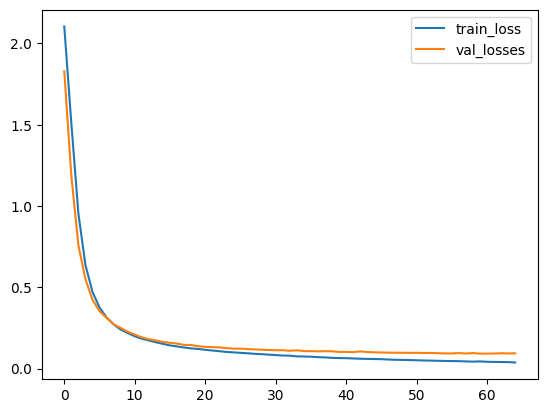

In [25]:
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_losses')
plt.legend()

## モデルオブジェクトの保存とロード


In [27]:
torch.save(model, 'sample_model.pth')

In [28]:
loaded_model = torch.load('sample_model.pth')

In [29]:
loaded_model 

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=64, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=10, bias=True)
)

## モデルパラメータの保存とロード

In [32]:
params = model.state_dict()

In [33]:
another_model = MLP(64, 30, 10)

In [34]:
another_model.load_state_dict(params)

<All keys matched successfully>

In [38]:
another_model.l1.weight

Parameter containing:
tensor([[-0.1429, -0.0765,  0.2083,  ...,  0.2763,  0.1304,  0.0492],
        [-0.1222, -0.0276,  0.0698,  ..., -0.6969, -0.4427, -0.2275],
        [ 0.0236, -0.0767, -0.0206,  ..., -0.0987, -0.2211,  0.0647],
        ...,
        [ 0.0351,  0.0556,  0.2809,  ...,  0.0484,  0.1712, -0.0567],
        [-0.0149, -0.0889,  0.2940,  ...,  0.1767, -0.0027,  0.1204],
        [ 0.0518, -0.0466,  0.1353,  ...,  0.1213,  0.1639,  0.1672]],
       requires_grad=True)

In [39]:
model.l1.weight

Parameter containing:
tensor([[-0.1429, -0.0765,  0.2083,  ...,  0.2763,  0.1304,  0.0492],
        [-0.1222, -0.0276,  0.0698,  ..., -0.6969, -0.4427, -0.2275],
        [ 0.0236, -0.0767, -0.0206,  ..., -0.0987, -0.2211,  0.0647],
        ...,
        [ 0.0351,  0.0556,  0.2809,  ...,  0.0484,  0.1712, -0.0567],
        [-0.0149, -0.0889,  0.2940,  ...,  0.1767, -0.0027,  0.1204],
        [ 0.0518, -0.0466,  0.1353,  ...,  0.1213,  0.1639,  0.1672]],
       requires_grad=True)

In [40]:
torch.save(model.state_dict(), 'sample_model_state_dict.pth')

In [41]:
another_model.load_state_dict(torch.load('sample_model_state_dict.pth'))

<All keys matched successfully>

In [47]:
def learn(model, train_loader, val_loader, optimizer, loss_func, num_epoch, early_stopping=None, save_path=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []

    # early_stopping用
    best_val_loss = float('inf')
    no_improve = 0  # カウント用
    
    
    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_accuracy = 0.0
    
    
        for train_batch, data in enumerate(train_loader):
    
            X, y = data
            
            # 順伝播と逆伝播の計算
            opt.zero_grad()
            # forward
            preds  = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
    
            # backword
            loss.backward()
            opt.step()
    
        # validtion
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_accuracy += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_accuracy/(val_batch + 1))
        print(f'epoch : {epoch}: train error : {train_losses[-1]}, validation error : {val_losses[-1]},val accuracy {val_accuracies[-1]}')
    
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            if save_path is not None:
                state = {
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'val_loss' : val_losses[-1],
                }
                torch.save(state, save_path)
        else:
            # 改善が見られなかったら
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break

    return train_losses, val_losses, val_accuracies

In [48]:
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr = learning_rate)
train_losses, val_losses, val_accuracy = learn(model, train_loader, val_loader,\
                                               opt, F.cross_entropy, num_epoch, early_stopping=5,save_path='checkpoint') 

epoch : 0: train error : 2.108624588118659, validation error : 1.8519695103168488,val accuracy 0.6041666666666666
epoch : 1: train error : 1.5357818259133234, validation error : 1.2291593949000041,val accuracy 0.8307291666666666
epoch : 2: train error : 0.9587878915998671, validation error : 0.7693126350641251,val accuracy 0.8776041666666666
epoch : 3: train error : 0.6259484536117977, validation error : 0.5290845781564713,val accuracy 0.90625
epoch : 4: train error : 0.4552525030242072, validation error : 0.41340890775124234,val accuracy 0.9192708333333334
epoch : 5: train error : 0.36245101557837595, validation error : 0.33931876346468925,val accuracy 0.9244791666666666
epoch : 6: train error : 0.3023951248990165, validation error : 0.29535413160920143,val accuracy 0.9296875
epoch : 7: train error : 0.26127568317784206, validation error : 0.27702680602669716,val accuracy 0.921875
epoch : 8: train error : 0.2347268968820572, validation error : 0.24348658323287964,val accuracy 0.940104

In [50]:
state = torch.load('checkpoint')
model.load_state_dict(state['model_state_dict'])

<All keys matched successfully>